In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 20
batch_size = 128
learning_rate = 0.01


In [23]:
# Transformations for the train and test sets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [24]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.max_pool(torch.relu(self.conv1(x)))
        x = self.max_pool(torch.relu(self.conv2(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
model = CNN().to(device)


### CNN without Regularization

In [25]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Training function
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Train the model
train(model, train_loader, criterion, optimizer, num_epochs)


Epoch [1/20], Loss: 0.0558
Epoch [2/20], Loss: 0.0297
Epoch [3/20], Loss: 0.0164
Epoch [4/20], Loss: 0.0055
Epoch [5/20], Loss: 0.0377
Epoch [6/20], Loss: 0.0034
Epoch [7/20], Loss: 0.1222
Epoch [8/20], Loss: 0.0088
Epoch [9/20], Loss: 0.0080
Epoch [10/20], Loss: 0.0066
Epoch [11/20], Loss: 0.0223
Epoch [12/20], Loss: 0.0015
Epoch [13/20], Loss: 0.0005
Epoch [14/20], Loss: 0.0042
Epoch [15/20], Loss: 0.0024
Epoch [16/20], Loss: 0.0322
Epoch [17/20], Loss: 0.0001
Epoch [18/20], Loss: 0.0002
Epoch [19/20], Loss: 0.0117
Epoch [20/20], Loss: 0.0003


In [26]:
# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Evaluate the model
evaluate(model, test_loader)


Accuracy of the model on the test images: 99.28 %


### Dropout Regularization

In [27]:
class CNNWithDropout(nn.Module):
    def __init__(self):
        super(CNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.max_pool(torch.relu(self.conv1(x)))
        x = self.max_pool(torch.relu(self.conv2(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model with dropout
model_dropout = CNNWithDropout().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_dropout.parameters(), lr=learning_rate, momentum=0.9)

# Train the model with dropout
train(model_dropout, train_loader, criterion, optimizer, num_epochs)

# Evaluate the model with dropout
evaluate(model_dropout, test_loader)


Epoch [1/20], Loss: 0.0919
Epoch [2/20], Loss: 0.1246
Epoch [3/20], Loss: 0.0229
Epoch [4/20], Loss: 0.0712
Epoch [5/20], Loss: 0.0448
Epoch [6/20], Loss: 0.0437
Epoch [7/20], Loss: 0.0294
Epoch [8/20], Loss: 0.0487
Epoch [9/20], Loss: 0.0463
Epoch [10/20], Loss: 0.0600
Epoch [11/20], Loss: 0.0042
Epoch [12/20], Loss: 0.0122
Epoch [13/20], Loss: 0.0510
Epoch [14/20], Loss: 0.0221
Epoch [15/20], Loss: 0.0093
Epoch [16/20], Loss: 0.0134
Epoch [17/20], Loss: 0.0727
Epoch [18/20], Loss: 0.0165
Epoch [19/20], Loss: 0.0287
Epoch [20/20], Loss: 0.0006
Accuracy of the model on the test images: 99.36 %


### L2 Regularization

In [28]:
# Initialize the model (same as the original model)
model_l2 = CNN().to(device)

# Loss and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_l2.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.01)

# Train the model with L2 regularization
train(model_l2, train_loader, criterion, optimizer, num_epochs)

# Evaluate the model with L2 regularization
evaluate(model_l2, test_loader)


Epoch [1/20], Loss: 0.1045
Epoch [2/20], Loss: 0.0584
Epoch [3/20], Loss: 0.0720
Epoch [4/20], Loss: 0.0778
Epoch [5/20], Loss: 0.0579
Epoch [6/20], Loss: 0.0359
Epoch [7/20], Loss: 0.0552
Epoch [8/20], Loss: 0.1235
Epoch [9/20], Loss: 0.0114
Epoch [10/20], Loss: 0.0767
Epoch [11/20], Loss: 0.0711
Epoch [12/20], Loss: 0.0663
Epoch [13/20], Loss: 0.0724
Epoch [14/20], Loss: 0.0668
Epoch [15/20], Loss: 0.0672
Epoch [16/20], Loss: 0.0621
Epoch [17/20], Loss: 0.0339
Epoch [18/20], Loss: 0.0296
Epoch [19/20], Loss: 0.1624
Epoch [20/20], Loss: 0.0670
Accuracy of the model on the test images: 98.19 %


### Data Augmentation

In [29]:
# Transformations for the train set with data augmentation
transform_augmented = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the augmented MNIST dataset
train_dataset_augmented = torchvision.datasets.MNIST(root='./data', train=True, transform=transform_augmented, download=True)
train_loader_augmented = DataLoader(dataset=train_dataset_augmented, batch_size=batch_size, shuffle=True)

# Initialize the model (same as the original model)
model_augmentation = CNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_augmentation.parameters(), lr=learning_rate, momentum=0.9)

# Train the model with data augmentation
train(model_augmentation, train_loader_augmented, criterion, optimizer, num_epochs)

# Evaluate the model with data augmentation
evaluate(model_augmentation, test_loader)


Epoch [1/20], Loss: 0.1722
Epoch [2/20], Loss: 0.1204
Epoch [3/20], Loss: 0.0770
Epoch [4/20], Loss: 0.1049
Epoch [5/20], Loss: 0.0534
Epoch [6/20], Loss: 0.0500
Epoch [7/20], Loss: 0.0294
Epoch [8/20], Loss: 0.0628
Epoch [9/20], Loss: 0.0410
Epoch [10/20], Loss: 0.0272
Epoch [11/20], Loss: 0.0233
Epoch [12/20], Loss: 0.0036
Epoch [13/20], Loss: 0.0471
Epoch [14/20], Loss: 0.0229
Epoch [15/20], Loss: 0.0039
Epoch [16/20], Loss: 0.0760
Epoch [17/20], Loss: 0.0542
Epoch [18/20], Loss: 0.0209
Epoch [19/20], Loss: 0.0100
Epoch [20/20], Loss: 0.0336
Accuracy of the model on the test images: 99.32 %


### Early Stopping

In [30]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Initialize the model (same as the original model)
model_early_stopping = CNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_early_stopping.parameters(), lr=learning_rate, momentum=0.9)

# # Training with early stopping
# def train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience=3):
#     early_stopping = EarlyStopping(patience=patience)
#     for epoch in range(num_epochs):
#         model.train()
#         for images, labels in train_loader:
#             images = images.to(device)
#             labels = labels.to(device)

#             # Forward pass
#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             # Backward and optimize
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#         # Validation loss
#         model.eval()
#         val_loss = 0
#         with torch.no_grad():
#             for images, labels in val_loader:
#                 images = images.to(device)
#                 labels = labels.to(device)
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item()
#         val_loss /= len(val_loader)
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

#         # Check early stopping
#         early_stopping(val_loss)
#         if early_stopping.early_stop:
#             print("Early stopping")
#             break

def train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience=3):
    early_stopping = EarlyStopping(patience=patience)
    train_acc = []
    val_acc = []
    for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_acc.append(train_accuracy)

        # Validation loss
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        val_acc.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%, Val Loss: {val_loss:.4f}')

        # Check early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return train_acc, val_acc


# Create validation loader
val_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Train the model with early stopping
train_with_early_stopping(model_early_stopping, train_loader, val_loader, criterion, optimizer, num_epochs)

# Evaluate the model with early stopping
evaluate(model_early_stopping, test_loader)


Epoch [1/20], Loss: 0.1412, Train Accuracy: 91.53%, Validation Accuracy: 97.39%, Val Loss: 0.0841
Epoch [2/20], Loss: 0.1297, Train Accuracy: 97.94%, Validation Accuracy: 98.58%, Val Loss: 0.0451
Epoch [3/20], Loss: 0.0848, Train Accuracy: 98.62%, Validation Accuracy: 98.79%, Val Loss: 0.0390
Epoch [4/20], Loss: 0.0111, Train Accuracy: 98.94%, Validation Accuracy: 99.19%, Val Loss: 0.0272
Epoch [5/20], Loss: 0.0204, Train Accuracy: 99.10%, Validation Accuracy: 98.81%, Val Loss: 0.0362
Epoch [6/20], Loss: 0.0082, Train Accuracy: 99.25%, Validation Accuracy: 99.41%, Val Loss: 0.0190
Epoch [7/20], Loss: 0.0187, Train Accuracy: 99.34%, Validation Accuracy: 99.50%, Val Loss: 0.0167
Epoch [8/20], Loss: 0.0099, Train Accuracy: 99.48%, Validation Accuracy: 99.49%, Val Loss: 0.0152
Epoch [9/20], Loss: 0.0174, Train Accuracy: 99.52%, Validation Accuracy: 99.69%, Val Loss: 0.0105
Epoch [10/20], Loss: 0.0030, Train Accuracy: 99.61%, Validation Accuracy: 99.66%, Val Loss: 0.0112
Epoch [11/20], Loss

In [32]:
class CNNWithNoise(nn.Module):
    def __init__(self):
        super(CNNWithNoise, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)
        self.noise = nn.Dropout(p=0.1)  # Simulate noise by dropout with a low rate

    def forward(self, x):
        x = self.noise(self.max_pool(torch.relu(self.conv1(x))))
        x = self.noise(self.max_pool(torch.relu(self.conv2(x))))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model with noise
model_noise = CNNWithNoise().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_noise.parameters(), lr=learning_rate, momentum=0.9)

# Train the model with noise
train(model_noise, train_loader, criterion, optimizer, num_epochs)

# Evaluate the model with noise
evaluate(model_noise, test_loader)


Epoch [1/20], Loss: 0.0948
Epoch [2/20], Loss: 0.0210
Epoch [3/20], Loss: 0.0132
Epoch [4/20], Loss: 0.0385
Epoch [5/20], Loss: 0.0170
Epoch [6/20], Loss: 0.0346
Epoch [7/20], Loss: 0.0054
Epoch [8/20], Loss: 0.0069
Epoch [9/20], Loss: 0.0106
Epoch [10/20], Loss: 0.0218
Epoch [11/20], Loss: 0.0877
Epoch [12/20], Loss: 0.0305
Epoch [13/20], Loss: 0.0218
Epoch [14/20], Loss: 0.0149
Epoch [15/20], Loss: 0.0134
Epoch [16/20], Loss: 0.0005
Epoch [17/20], Loss: 0.0044
Epoch [18/20], Loss: 0.0056
Epoch [19/20], Loss: 0.0023
Epoch [20/20], Loss: 0.0078
Accuracy of the model on the test images: 99.17 %


### Random Weight Initialization

In [33]:
class CNNWithRandomInit(nn.Module):
    def __init__(self):
        super(CNNWithRandomInit, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)
        self._initialize_weights()

    def forward(self, x):
        x = self.max_pool(torch.relu(self.conv1(x)))
        x = self.max_pool(torch.relu(self.conv2(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

# Initialize the model with random weight initialization
model_random_init = CNNWithRandomInit().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_random_init.parameters(), lr=learning_rate, momentum=0.9)

# Train the model with random weight initialization
train(model_random_init, train_loader, criterion, optimizer, num_epochs)

# Evaluate the model with random weight initialization
evaluate(model_random_init, test_loader)


Epoch [1/20], Loss: 0.1013
Epoch [2/20], Loss: 0.0824
Epoch [3/20], Loss: 0.0156
Epoch [4/20], Loss: 0.0258
Epoch [5/20], Loss: 0.0087
Epoch [6/20], Loss: 0.0052
Epoch [7/20], Loss: 0.0006
Epoch [8/20], Loss: 0.0074
Epoch [9/20], Loss: 0.0112
Epoch [10/20], Loss: 0.0208
Epoch [11/20], Loss: 0.0014
Epoch [12/20], Loss: 0.0132
Epoch [13/20], Loss: 0.0006
Epoch [14/20], Loss: 0.0080
Epoch [15/20], Loss: 0.0067
Epoch [16/20], Loss: 0.0003
Epoch [17/20], Loss: 0.0021
Epoch [18/20], Loss: 0.0023
Epoch [19/20], Loss: 0.0077
Epoch [20/20], Loss: 0.0004
Accuracy of the model on the test images: 98.87 %


### L1 Normalization

In [34]:
# Custom loss function with L1 regularization
class L1LossWithReg(nn.Module):
    def __init__(self, model, l1_lambda):
        super(L1LossWithReg, self).__init__()
        self.model = model
        self.l1_lambda = l1_lambda
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        l1_norm = sum(p.abs().sum() for p in self.model.parameters())
        loss = self.criterion(outputs, targets) + self.l1_lambda * l1_norm
        return loss

# Initialize the model (same as the original model)
model_l1 = CNN().to(device)

# Loss and optimizer
l1_lambda = 0.01
criterion = L1LossWithReg(model_l1, l1_lambda)
optimizer = optim.SGD(model_l1.parameters(), lr=learning_rate, momentum=0.9)

# Train the model with L1 regularization
train(model_l1, train_loader, criterion, optimizer, num_epochs)

# Evaluate the model with L1 regularization
evaluate(model_l1, test_loader)


Epoch [1/20], Loss: 1.2480
Epoch [2/20], Loss: 1.1345
Epoch [3/20], Loss: 1.1090
Epoch [4/20], Loss: 1.0015
Epoch [5/20], Loss: 1.1782
Epoch [6/20], Loss: 1.1070
Epoch [7/20], Loss: 1.2250
Epoch [8/20], Loss: 1.0860
Epoch [9/20], Loss: 1.0574
Epoch [10/20], Loss: 1.2485
Epoch [11/20], Loss: 1.0360
Epoch [12/20], Loss: 1.5340
Epoch [13/20], Loss: 1.0479
Epoch [14/20], Loss: 1.1316
Epoch [15/20], Loss: 1.0573
Epoch [16/20], Loss: 1.3028
Epoch [17/20], Loss: 1.1129
Epoch [18/20], Loss: 1.1791
Epoch [19/20], Loss: 1.0458
Epoch [20/20], Loss: 1.0305
Accuracy of the model on the test images: 83.63 %


### Compare

In [35]:
def train_with_logging(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    train_acc = []
    val_acc = []
    for epoch in range(num_epochs):
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc.append(100 * correct / total)
        val_acc.append(evaluate(model, test_loader, logging=False))
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_acc[-1]:.2f}%, Validation Accuracy: {val_acc[-1]:.2f}%')
    return train_acc, val_acc

def evaluate(model, test_loader, logging=True):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        if logging:
            print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
        return 100 * correct / total

In [36]:
histories = []

# Early Stopping
model_early_stopping = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_early_stopping.parameters(), lr=learning_rate, momentum=0.9)
train_acc_early_stopping, val_acc_early_stopping = train_with_early_stopping(model_early_stopping, train_loader, val_loader, criterion, optimizer, num_epochs)
histories.append({'label': 'Early Stopping', 'train_acc': train_acc_early_stopping, 'val_acc': val_acc_early_stopping})


# No regularization
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_acc, val_acc = train_with_logging(model, train_loader, criterion, optimizer, num_epochs)
histories.append({'label': 'No Regularization', 'train_acc': train_acc, 'val_acc': val_acc})

# Dropout
model_dropout = CNNWithDropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_dropout.parameters(), lr=learning_rate, momentum=0.9)
train_acc_dropout, val_acc_dropout = train_with_logging(model_dropout, train_loader, criterion, optimizer, num_epochs)
histories.append({'label': 'Dropout', 'train_acc': train_acc_dropout, 'val_acc': val_acc_dropout})

# L2 Regularization
model_l2 = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_l2.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.01)
train_acc_l2, val_acc_l2 = train_with_logging(model_l2, train_loader, criterion, optimizer, num_epochs)
histories.append({'label': 'L2 Regularization', 'train_acc': train_acc_l2, 'val_acc': val_acc_l2})

# Data Augmentation
model_augmentation = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_augmentation.parameters(), lr=learning_rate, momentum=0.9)
train_acc_augmentation, val_acc_augmentation = train_with_logging(model_augmentation, train_loader_augmented, criterion, optimizer, num_epochs)
histories.append({'label': 'Data Augmentation', 'train_acc': train_acc_augmentation, 'val_acc': val_acc_augmentation})

# # Early Stopping
# model_early_stopping = CNN().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model_early_stopping.parameters(), lr=learning_rate, momentum=0.9)
# train_acc_early_stopping, val_acc_early_stopping = train_with_early_stopping(model_early_stopping, train_loader, val_loader, criterion, optimizer, num_epochs)
# histories.append({'label': 'Early Stopping', 'train_acc': train_acc_early_stopping, 'val_acc': val_acc_early_stopping})

# Adding Noise
model_noise = CNNWithNoise().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_noise.parameters(), lr=learning_rate, momentum=0.9)
train_acc_noise, val_acc_noise = train_with_logging(model_noise, train_loader, criterion, optimizer, num_epochs)
histories.append({'label': 'Adding Noise', 'train_acc': train_acc_noise, 'val_acc': val_acc_noise})

# Random Weight Initialization
model_random_init = CNNWithRandomInit().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_random_init.parameters(), lr=learning_rate, momentum=0.9)
train_acc_random_init, val_acc_random_init = train_with_logging(model_random_init, train_loader, criterion, optimizer, num_epochs)
histories.append({'label': 'Random Weight Initialization', 'train_acc': train_acc_random_init, 'val_acc': val_acc_random_init})

# L1 Regularization
model_l1 = CNN().to(device)
l1_lambda = 0.01
criterion = L1LossWithReg(model_l1, l1_lambda)
optimizer = optim.SGD(model_l1.parameters(), lr=learning_rate, momentum=0.9)
train_acc_l1, val_acc_l1 = train_with_logging(model_l1, train_loader, criterion, optimizer, num_epochs)
histories.append({'label': 'L1 Regularization', 'train_acc': train_acc_l1, 'val_acc': val_acc_l1})


Epoch [1/20], Loss: 0.1167, Train Accuracy: 91.46%, Validation Accuracy: 97.66%, Val Loss: 0.0807
Epoch [2/20], Loss: 0.0193, Train Accuracy: 97.93%, Validation Accuracy: 98.49%, Val Loss: 0.0481
Epoch [3/20], Loss: 0.0190, Train Accuracy: 98.55%, Validation Accuracy: 98.62%, Val Loss: 0.0439
Epoch [4/20], Loss: 0.0162, Train Accuracy: 98.85%, Validation Accuracy: 99.08%, Val Loss: 0.0307
Epoch [5/20], Loss: 0.0112, Train Accuracy: 99.06%, Validation Accuracy: 99.25%, Val Loss: 0.0252
Epoch [6/20], Loss: 0.0081, Train Accuracy: 99.27%, Validation Accuracy: 99.25%, Val Loss: 0.0236
Epoch [7/20], Loss: 0.0084, Train Accuracy: 99.34%, Validation Accuracy: 99.41%, Val Loss: 0.0190
Epoch [8/20], Loss: 0.0179, Train Accuracy: 99.47%, Validation Accuracy: 99.59%, Val Loss: 0.0143
Epoch [9/20], Loss: 0.0051, Train Accuracy: 99.57%, Validation Accuracy: 99.63%, Val Loss: 0.0124
Epoch [10/20], Loss: 0.0042, Train Accuracy: 99.65%, Validation Accuracy: 99.74%, Val Loss: 0.0099
Epoch [11/20], Loss

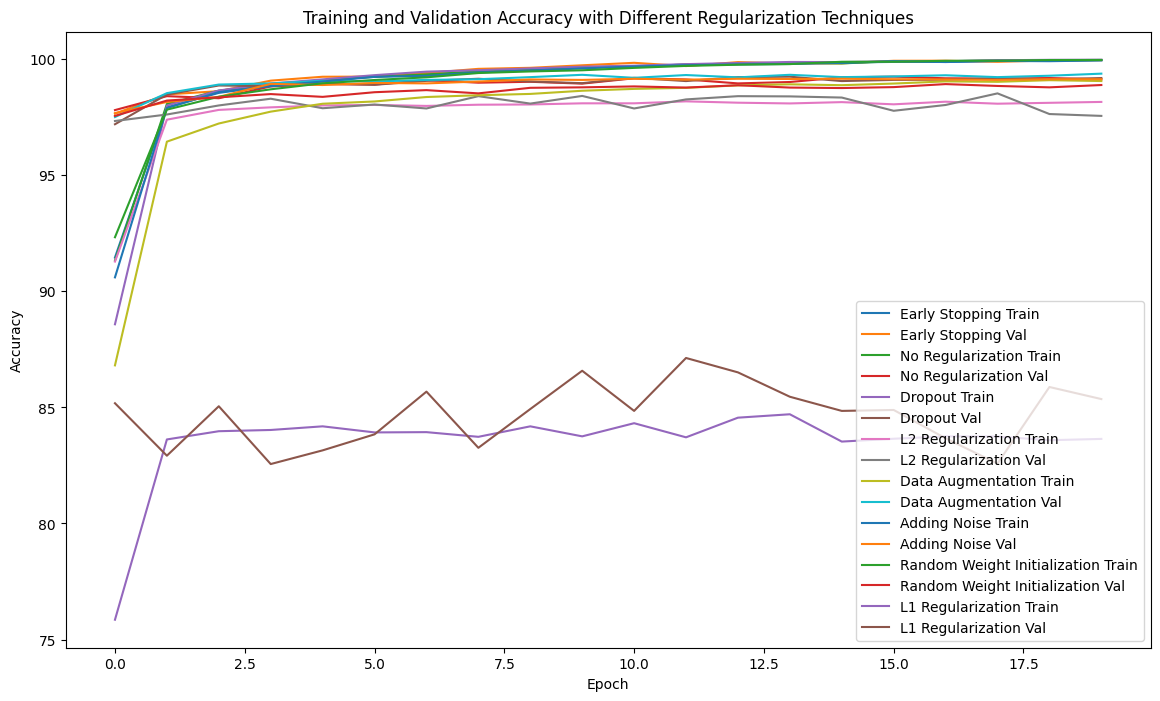

In [37]:
def plot_results(histories, title):
    plt.figure(figsize=(14, 8))
    for history in histories:
        plt.plot(history['train_acc'], label=history['label'] + ' Train')
        plt.plot(history['val_acc'], label=history['label'] + ' Val')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_results(histories, 'Training and Validation Accuracy with Different Regularization Techniques')
